# Tail Risk Modeling and VaR Estimation of a 60/40 Portfolio

In this project I want to model the tail risk and estimate the daily **Value of Risk(VaR)** of a portfolio that consists of 60% S&P 500 equity and 40% U.S. Treasury bonds. For simplicity and convinience, I choose iShare's 20+ Year Treasury Bond ETF (TLT) for the bonds portion. The data is obtained from Yahoo Finance.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
#from statsmodels.distributions.copula.api import StudentTCopula   # Newest version of scipy leads to import error, may need an alternative
import openturns as ot
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

## 1. Exploratory Data Analysis

In [2]:
# Download sp500 data from yahoo finance
start_date = "2010-01-01"
end_date = "2025-06-30"

sp500_data = yf.download("^GSPC", start=start_date, end=end_date, auto_adjust=True)     # S&P 500 index
betf_data = yf.download("TLT", start=start_date, end=end_date, auto_adjust=True)        # ishares 20+ Year Treasury Bond
pd.concat([sp500_data.Close, betf_data.Close], axis=1).head()                           # Daily close price of both assets
#sp500_data.describe()
#betf_data.describe()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC,TLT
Date,,
2010-01-04,1132.989990,58.033890
2010-01-05,1136.520020,58.408695
2010-01-06,1137.140015,57.626820
2010-01-07,1141.689941,57.723770
2010-01-08,1144.979980,57.697918


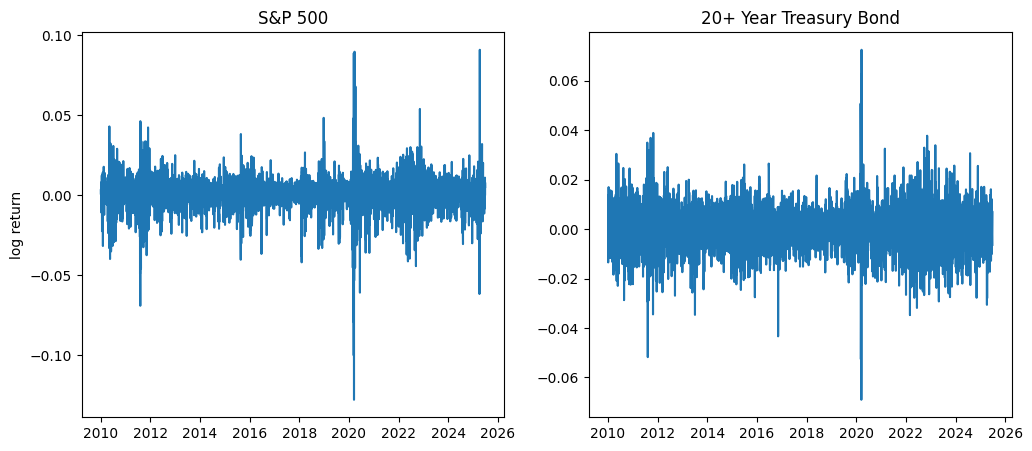

In [3]:
# Compute log return
sp500_data['logReturn'] = np.log(sp500_data.Close / sp500_data.Close.shift()).values   # log return
betf_data['logReturn'] = np.log((betf_data.Close / betf_data.Close.shift())).values

# Plot log return
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(sp500_data.logReturn)
ax[1].plot(betf_data.logReturn)
ax[0].set_title("S&P 500")
ax[1].set_title("20+ Year Treasury Bond")
ax[0].set_ylabel("log return")
plt.show()

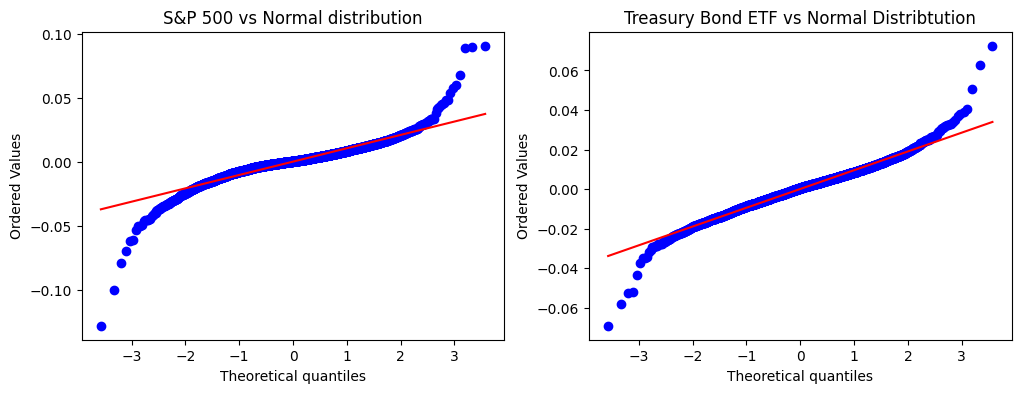

In [4]:
# Q-Q plots to check if there exist heavy tails (Compared to a Gaussian distribution)
sp_lr = sp500_data.logReturn.dropna()
be_lr = betf_data.logReturn.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
stats.probplot(sp_lr, dist='norm', plot=ax[0])
stats.probplot(be_lr, dist='norm', plot=ax[1])
ax[0].set_title("S&P 500 vs Normal distribution")
ax[1].set_title("Treasury Bond ETF vs Normal Distribtution")
plt.show()

## 2. Fitting marginal loss distributions

Next we want to fit a distribution to the negative log-return (loss) of S&P 500 and TLT. Since we have observed that the marginal distributions are both heavy-tailed, we can try to fit the marginal distributions by using a **Peak-Over-Threshold (POT)** strategy. Specifically, we fit the Generalized Pareto Distribution (GPD) to the tails of each asset's loss distribution, which allows a more accurate estimation of tail probabilities and the VaR.

### Choosing a threshold

First, we need to choose an appropriate threshold so that the excess losses above this level approximately follow a Generalized Pareto Distribution (GPD). We want this threshold to be

1. Stable, which means the estimation results of parameters are not sensitive to small changes in the choice of the threshold.
2. Not too large in case there is not enough points for tail estimation and not too small in case large bulk of data biases the estimation result

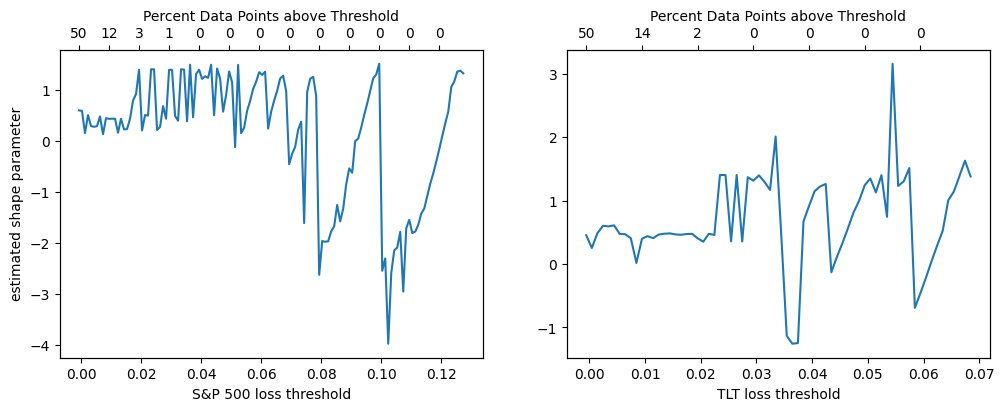

In [5]:
# Plot exstimated shape parameter of GPD vs choice of threshold

def shape_plot_values(data):
    '''Return values that will be used in the plot'''
    data_sort = sorted(data)
    q_bound = np.quantile(data_sort, 0.5)            # The lower bound of the set of threshold choices
    thres = np.arange(q_bound, data.max(), 0.001)    
    shape, ex_thres_per = [], []
    for t in thres:
        e = data[data > t]       # data exceeding the threshold
        excess = e - t           
        e_percent = len(e)/len(data)
        ex_thres_per.append(e_percent)
        # Fit GPD
        xi = stats.genpareto.fit(excess)[0]
        shape.append(xi)
    return thres, shape, ex_thres_per

fig, ax = plt.subplots(1,2, figsize=(12,4))
x1, y1, u1 = shape_plot_values(-sp_lr)    # S&P 500
x2, y2, u2 = shape_plot_values(-be_lr)     # TLT
ax[0].plot(x1, y1)
ax[1].plot(x2, y2)
ax_top1 = ax[0].twiny()
ax_top2 = ax[1].twiny()
ax_top1.set_xlim(ax[0].get_xlim())
ax_top1.set_xticks(x1[::10])
ax_top1.set_xticklabels([int(100*u) for u in u1[::10]])
ax_top2.set_xlim(ax[1].get_xlim())
ax_top2.set_xticks(x2[::10])
ax_top2.set_xticklabels([int(100*u) for u in u2[::10]])
ax[0].set_xlabel("S&P 500 loss threshold")
ax[0].set_ylabel("estimated shape parameter")
ax[1].set_xlabel("TLT loss threshold")
ax_top1.set_xlabel("Percent Data Points above Threshold")
ax_top2.set_xlabel("Percent Data Points above Threshold")
plt.show()

From the above plots, we can see that S&P 500 loss threshold $\approx$ 0.01 and TLT loss threshold $\approx$ 0.013 may be a good choice since the parameter estimation seems relatively stable and the percentage of data exceeding both thresholds are around 10% ~ 15%. We can double check our choices by plotting the mean excess plot, which should show a relation close to linear.

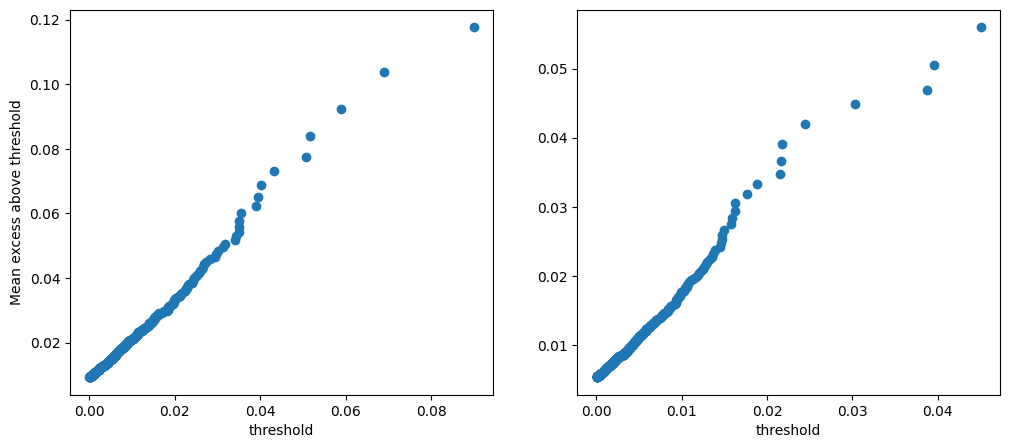

In [6]:
# According to above plots, we choose 0.01 as the threshold for the loss of S&P 500
#                                     0.013 as the threshold for the loss of TLT

# Mean excess plot 
def mean_excess(excess):
    ''' Calculate the mean excess exceeding the given threshold '''
    res = []
    for i in range(0, len(excess)-1):
        res.append(np.mean(excess[i+1:]))
    return res
    
sp_thres = 0.01
sp_excess = -sp500_data.logReturn[-sp500_data.logReturn > sp_thres] - sp_thres     
sp_mean_excess = mean_excess(sorted(sp_excess))

be_thres = 0.013
be_excess = -betf_data.logReturn[-betf_data.logReturn > be_thres] - be_thres
be_mean_excess = mean_excess(sorted(be_excess))

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(sorted(sp_excess)[:-1],sp_mean_excess)
ax[1].scatter(sorted(be_excess)[:-1],be_mean_excess)
ax[0].set_xlabel("threshold")
ax[1].set_xlabel("threshold")
ax[0].set_ylabel("Mean excess above threshold")
plt.show()

### Peaks-Over-Threshold method

After choosing a threshold, we can start the fitting process. We fit a GPD to the portion exceeding the threshold and use a nonparametric approach to estimate the distribution on the portion below the threshold.

In [7]:
# Fit tails to GPD (thres - x)
c1, loc1, s1 = stats.genpareto.fit(sp_excess, floc=0)   # S&P 500     # c: shape parameter, s: scale parameter
c2, loc2, s2 = stats.genpareto.fit(be_excess, floc=0)   # TLT
c1, c2         

(np.float64(0.13510780292586255), np.float64(0.14210684870833795))

In [8]:
# Define mixed fitted distribution
def cdf_est(x, thres, nofex, c, s, data):
    '''Empirical estimate of cdf'''
    sdata = sorted(data)
    n = len(data)
    exp = nofex/n
    if x <= thres:
        for i in range(n):
            if x >= sdata[i] and x < sdata[i+1]: return (i+0.5) / n    # [(i+1)-0.5]/n
    else:
        return 1 - exp*np.pow((1 + c*(x-thres)/s),(1/s))

def quantile_est(p, thres, nofex, c, s, data):
    '''Empirical estimate of quantile'''
    sdata = sorted(data)
    n = len(data)
    exp = nofex/n
    if p <= 1-exp:
        for i in range(n):
            if (i+0.5)/n >= p: return sdata[i]
    else:
        return thres + (s/c)*(((1-p)/exp)**(-c) - 1)

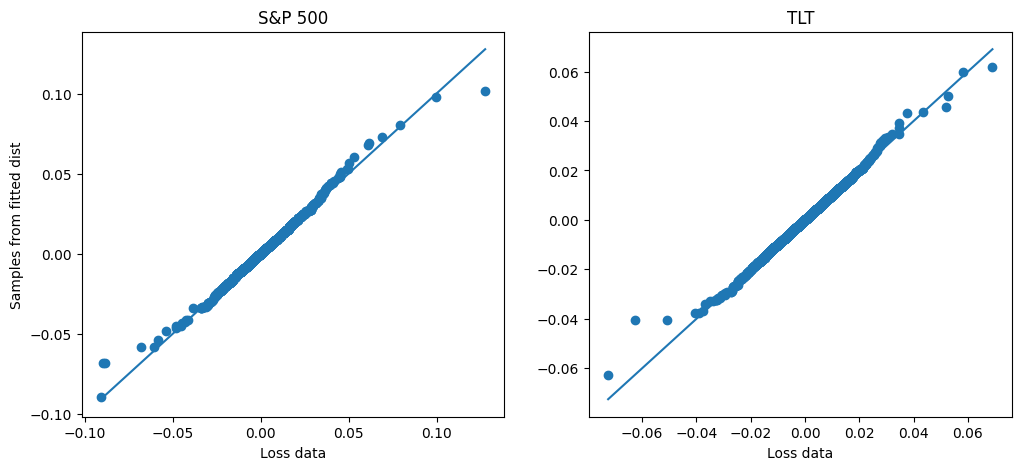

In [35]:
# Test fitted distribtution

# rng = np.random.default_rng(134)        # For reproducing results
# U = rng.random.uniform(0,1,size=3894)   

U = np.random.uniform(0,1,size=3894)
X1, X2 = [], []
for u in U:
    X1.append(quantile_est(u, sp_thres, len(sp_excess), c1, s1, -sp_lr))
    X2.append(quantile_est(u, be_thres, len(be_excess), c2, s2, -be_lr))

# Empirical Q-Q plot
x1 = sorted(-sp_lr)
x2 = sorted(-be_lr)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(x1, sorted(X1))
ax[0].plot(x1,x1)
ax[0].set_xlabel("Loss data")
ax[0].set_ylabel("Samples from fitted dist")
ax[0].set_title("S&P 500")
ax[1].scatter(x2, sorted(X2))
ax[1].plot(x2,x2)
ax[1].set_xlabel("Loss data")
ax[1].set_title("TLT")
plt.show()

### Estimate VaR for each asset

We can estimate the VaR of both assets with a given level using the fitted distribution and compare it to empirical VaR given by the empirical estimate of the percentile. 

In [33]:
p = 0.01     # level    

# Empirical VaR
sp500_eVaR = np.quantile(sorted(-sp_lr), 1-p)
betf_eVaR = np.quantile(sorted(-be_lr), 1-p)

# GPD model VaR
sp500_VaR = quantile_est(1-p, sp_thres, len(sp_excess), c1, s1, -sp_lr)
betf_VaR = quantile_est(1-p, be_thres, len(be_excess), c2, s2, -be_lr)

# Gaussian model VaR
mu_sp, sig_sp = stats.norm.fit(-sp_lr)   # Fit Gaussian
mu_be, sig_be = stats.norm.fit(-be_lr)
sp500_gVaR = stats.norm.ppf(1-p, loc=mu_sp, scale=sig_sp)
betf_gVaR = stats.norm.ppf(1-p, loc=mu_be, scale=sig_be)

print(f"Empirical {100*p}% VaR : ")
print("------------------------------------")
print(f"S&P 500 : {round(100*sp500_eVaR,2)}%")
print(f"TLT     : {round(100*betf_eVaR,2)}%")
print("")
print(f"GPD model {100*p}% VaR : ")
print("------------------------------------")
print(f"S&P 500 : {round(100*sp500_VaR,2)}%")
print(f"TLT     : {round(100*betf_VaR,2)}%")
print("")
print(f"Gaussian model {100*p}% VaR : ")
print("------------------------------------")
print(f"S&P 500 : {round(100*sp500_gVaR,2)}%")
print(f"TLT     : {round(100*betf_gVaR,2)}%")

Empirical 1.0% VaR : 
------------------------------------
S&P 500 : 3.24%
TLT     : 2.33%

GPD model 1.0% VaR : 
------------------------------------
S&P 500 : 3.31%
TLT     : 2.4%

Gaussian model 1.0% VaR : 
------------------------------------
S&P 500 : 2.53%
TLT     : 2.22%


## 3. Model dependence with Copulas

After modeling the marginal distributions, we need to capture the dependence structure between the two assets.  

We fit different copula families (e.g., Gaussian, Student's t) to the rank-transformed returns and compare their goodness of fit.  

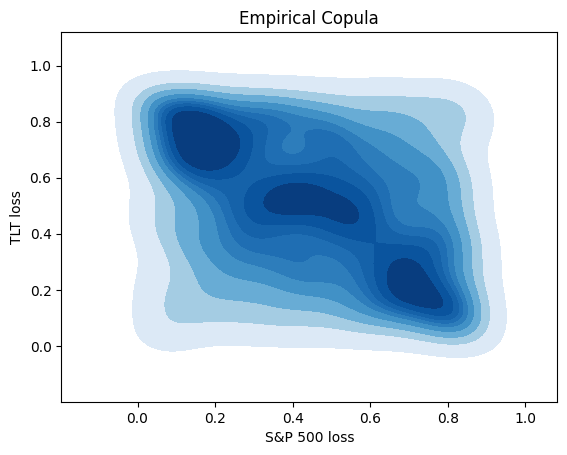

In [15]:
# Transform data to the unit domain [0,1] using the estimated CDF
sp_uni, be_uni = [], []
for i in range(len(-sp_lr)):
    est1 = cdf_est(-sp_lr.iloc[i], sp_thres, len(sp_excess), c1, s1, -sp_lr)
    est2 = cdf_est(-be_lr.iloc[i], be_thres, len(be_excess), c2, s2, -be_lr)
    if (est1 > 1) or (est2 > 1) or (est1 < 0) or (est2 < 0):
        continue
    sp_uni.append(est1)
    be_uni.append(est2)


# KDE plot of the empirical copula
sns.kdeplot(x=sp_uni, y=be_uni, fill=True, cmap="Blues", thresh=0.05)
plt.xlabel('S&P 500 loss')
plt.ylabel('TLT loss')
plt.title('Empirical Copula')
plt.show()

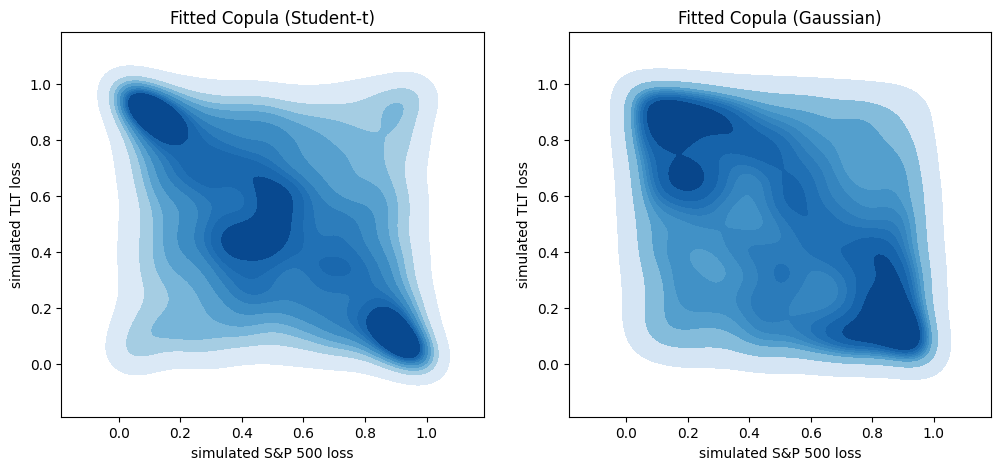

In [26]:
# Fit a Student T Copula & a Gaussian Copula
copula_st = ot.StudentCopulaFactory().build(ot.Sample(np.column_stack([sp_uni, be_uni]).tolist()))
copula_ga = ot.NormalCopulaFactory().build(ot.Sample(np.column_stack([sp_uni, be_uni]).tolist()))

sample_st = copula_st.getSample(10000).asDataFrame()
sample_ga = copula_ga.getSample(10000).asDataFrame()

# Plot fitted copula
fig, ax = plt.subplots(1,2, figsize=(12,5))
#ax[0].hist2d(sample_st['v0'], sample_st['v1'], bins=30)
#ax[0].scatter(sample_st['v0'], sample_st['v1'])
sns.kdeplot(x=sample_st['v0'], y=sample_st['v1'], fill=True, cmap="Blues", thresh=0.05, ax=ax[0])
ax[0].set_xlabel('simulated S&P 500 loss')
ax[0].set_ylabel('simulated TLT loss')
ax[0].set_title('Fitted Copula (Student-t)')
#ax[1].hist2d(sample_ga['v0'], sample_ga['v1'], bins=30)
#ax[1].scatter(sample_ga['v0'], sample_ga['v1'])
sns.kdeplot(x=sample_ga['v0'], y=sample_ga['v1'], fill=True, cmap="Blues", thresh=0.05, ax=ax[1])
ax[1].set_xlabel('simulated S&P 500 loss')
ax[1].set_ylabel('simulated TLT loss')
ax[1].set_title('Fitted Copula (Gaussian)')
plt.show()

We can see that both copulas both show a dependence structure indicating a negative correlation. The main difference is that the copula of Student-t type captures tail dependence, producing more extreme loss scenarios.

## 5. Estimate portfolio $VaR_p$ with copulas

In [34]:
# Evaluate VaR_p using Monte Carlo simulation

# get marginal samples using inverse cdf
sp_sample_st = [quantile_est(u, sp_thres, len(sp_excess), c1, s1, -sp_lr) for u in sample_st.v0]    # Student-t copula
be_sample_st = [quantile_est(v, be_thres, len(be_excess), c2, s2, -be_lr) for v in sample_st.v1]

sp_sample_ga = [quantile_est(u, sp_thres, len(sp_excess), c1, s1, -sp_lr) for u in sample_ga.v0]    # Gaussian copula
be_sample_ga = [quantile_est(v, be_thres, len(be_excess), c2, s2, -be_lr) for v in sample_ga.v1]

# Calculate log return of the porfolio (60% S&P 500, 40% US Treasury bond etf)
portfolio_lr_st = [0.6*c[0] + 0.4*c[1] for c in np.column_stack([sp_sample_st, be_sample_st])]
portfolio_lr_ga = [0.6*c[0] + 0.4*c[1] for c in np.column_stack([sp_sample_ga, be_sample_ga])]
port_VaR_st = np.quantile(sorted(portfolio_lr_st), 1-p)
port_VaR_ga = np.quantile(sorted(portfolio_lr_ga), 1-p)

print(f'The {100*p}% daily VaR of the 60/40 portfolio is :')
print(f'(Student-t copula) : {round(100*port_VaR_st,2)}%')
print(f'(Gaussian copula)  : {round(100*port_VaR_ga,2)}%')

The 1.0% daily VaR of the 60/40 portfolio is :
(Student-t copula) : 2.07%
(Gaussian copula)  : 1.91%


We can observe that:

1. We get a more _optimistic_ evaluation on possible losses if we use _Gaussian_ copulas, just like the single assets do if we use a Gaussian distribution.
   
2. Compared to the estimated VaR (GPD model) of individual assets, we get a smaller VaR estimate with a 60/40 portfolio. Which means this portfolio reduced risk by adding a negatively correlated asset.

     
3. Compared with the difference between estimated VaRs of S&P 500 using different models (GPD - Gaussian: 0.78%), we get a smaller difference between estimated VaRs of the 60/40 portfolio (Student-t - Gaussian: 0.16%), which means this diversified portfolio is less sensitive to different choices of distribution choices.